=== Resultados (Método: SNR Máximo, Ruido Gaussiano) ===
Masa estimada (máx SNR): 6.000 M_sun
SNR máximo: 9749.172
Incertidumbre 95% (criterio SNR>=95%): ±0.112 M_sun (rango [5.870, 6.095])
Valor ponderado por SNR: 9.291 M_sun
Valor ponderado por posterior (media): 5.984 M_sun
--- Tiempos ---
Tiempo total de la estimación: 1.067 s
Tiempo total dentro del bucle: 1.067 s
Tiempo promedio por masa: 0.053 s
Tiempo por iteración (primeras 5): 0.055 | 0.055 | 0.055 | 0.054 | 0.054


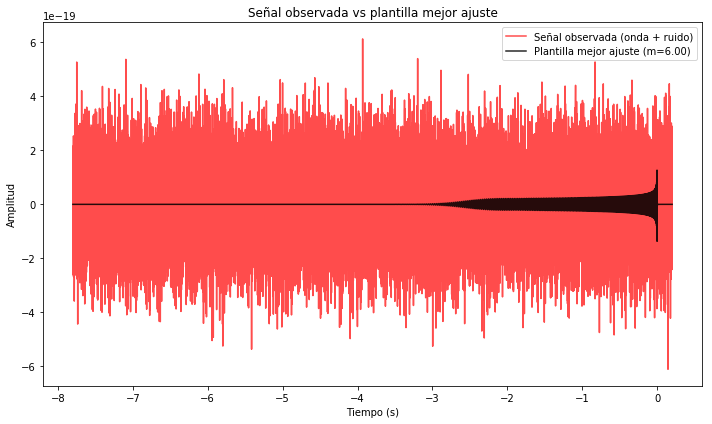

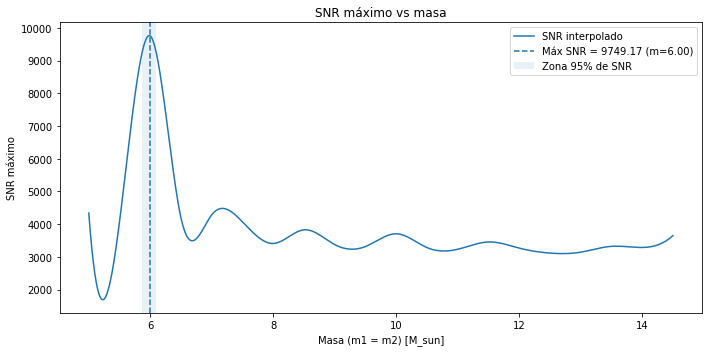

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from scipy.interpolate import interp1d

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 40.0

# ================================
# 1) Señal "real" (onda + ruido)
# ================================
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=delta_t,
    f_lower=f_low
)
t = hp_rom.sample_times.numpy()
signal = np.array(hp_rom)

# Ruido gaussiano escalado
gaussian_noise = np.random.normal(size=len(t))
scaled_noise = gaussian_noise * np.max(np.abs(signal))
observed_signal = signal + scaled_noise
observed_ts = TimeSeries(observed_signal, delta_t=delta_t)

# ================================
# 2) PSD
# ================================
data_fd = observed_ts.to_frequencyseries()
psd = aLIGOZeroDetHighPower(len(data_fd), data_fd.delta_f, 20.0)

# ================================
# 3) Búsqueda por matched filter (m1=m2)
# ================================
masses = np.arange(5.0, 15.0, 0.5)
snr_values = []
iter_times = []

# --- medir tiempo total
t_start_total = time.time()

# --- medir solo el bucle
t_start_loop = time.time()

for m in masses:
    iter_start = time.time()

    hp, _ = get_td_waveform(
        approximant='SEOBNRv4_ROM',
        mass1=m,
        mass2=m,
        delta_t=delta_t,
        f_lower=f_low
    )
    hp.resize(len(observed_ts))
    hp_fd = hp.to_frequencyseries()
    snr = matched_filter(hp_fd, data_fd, psd=psd, low_frequency_cutoff=f_low)
    peak_snr = np.abs(snr.numpy()).max()
    snr_values.append(peak_snr)

    iter_end = time.time()
    iter_times.append(iter_end - iter_start)

t_end_loop = time.time()
t_end_total = time.time()

snr_values = np.array(snr_values)
best_idx = np.argmax(snr_values)
best_mass = masses[best_idx]
best_snr = snr_values[best_idx]

# ================================
# 4) Interpolación fina de SNR(m)
# ================================
interp = interp1d(masses, snr_values, kind='cubic')
fine_masses = np.linspace(masses.min(), masses.max(), 5000)
fine_snr = interp(fine_masses)

# --- Incertidumbre 95% (heurística)
mask95 = fine_snr >= 0.95 * best_snr
if np.any(mask95):
    m_lo_95 = fine_masses[mask95].min()
    m_hi_95 = fine_masses[mask95].max()
    half_width_95 = 0.5 * (m_hi_95 - m_lo_95)
else:
    m_lo_95 = best_mass
    m_hi_95 = best_mass
    half_width_95 = 0.0

# --- Posterior discreto: p(m) ∝ exp(0.5 * SNR(m)^2)
rho2 = fine_snr**2
rho2_shift = rho2 - rho2.max()
w_post = np.exp(0.5 * rho2_shift)
post = w_post / w_post.sum()

# Media posterior y IC 68%
mean_post = np.sum(fine_masses * post)
cdf = np.cumsum(post)
m16 = np.interp(0.16, cdf, fine_masses)
m84 = np.interp(0.84, cdf, fine_masses)

# --- Ponderados
mass_weighted_snr = np.sum(fine_masses * fine_snr) / np.sum(fine_snr)
mass_weighted_post = mean_post

# ================================
# 5) Estadísticas de tiempo
# ================================
total_time = t_end_total - t_start_total
loop_time = t_end_loop - t_start_loop
avg_time = loop_time / len(masses)

# ================================
# 6) Reporte completo
# ================================
print("=== Resultados (Método: SNR Máximo, Ruido Gaussiano) ===")
print("Masa estimada (máx SNR): {:.3f} M_sun".format(best_mass))
print("SNR máximo: {:.3f}".format(best_snr))
print("Incertidumbre 95% (criterio SNR>=95%): ±{:.3f} M_sun (rango [{:.3f}, {:.3f}])"
      .format(half_width_95, m_lo_95, m_hi_95))      
print("Valor ponderado por SNR: {:.3f} M_sun".format(mass_weighted_snr))
print("Valor ponderado por posterior (media): {:.3f} M_sun".format(mass_weighted_post))
print("--- Tiempos ---")
print("Tiempo total de la estimación: {:.3f} s".format(total_time))
print("Tiempo total dentro del bucle: {:.3f} s".format(loop_time))
print("Tiempo promedio por masa: {:.3f} s".format(avg_time))
print("Tiempo por iteración (primeras 5): {}".format(
    " | ".join("{:.3f}".format(x) for x in iter_times[:5])
))


# ================================
# 7) Gráfico 1: señal vs plantilla óptima
# ================================
hp_best, _ = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=best_mass,
    mass2=best_mass,
    delta_t=delta_t,
    f_lower=f_low
)
hp_best.resize(len(observed_ts))

plt.figure(figsize=(10,6))
plt.plot(t, observed_signal, label=u"Señal observada (onda + ruido)", color='red', alpha=0.7)
plt.plot(hp_best.sample_times, hp_best,
         label="Plantilla mejor ajuste (m={:.2f})".format(best_mass), color='black', alpha=0.85)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title(u"Señal observada vs plantilla mejor ajuste")
plt.legend()
plt.tight_layout()
plt.show()

# ================================
# 8) Gráfico 2: SNR vs masa
# ================================
plt.figure(figsize=(10,5))
plt.plot(fine_masses, fine_snr, label="SNR interpolado")
plt.axvline(best_mass, linestyle='--',
            label=u"Máx SNR = {:.2f} (m={:.2f})".format(best_snr, best_mass))
plt.axvspan(m_lo_95, m_hi_95, alpha=0.1,
            label="Zona 95% de SNR")
plt.xlabel("Masa (m1 = m2) [M_sun]")
plt.ylabel(u"SNR máximo")
plt.title(u"SNR máximo vs masa")
plt.legend()
plt.tight_layout()
plt.show()



=== Resultados (Método: Match Normalizado, Ruido Gaussiano) ===
Masa estimada (máx match): 6.002 M_sun
Match máximo: 0.154123
Incertidumbre 95% (criterio match ≥ 95% del máximo): ±0.003 M_sun (rango [5.998, 6.004])
Masa ponderada por match: 6.274 M_sun
--- Tiempos ---
Tiempo total de la estimación: 23.126 s
Tiempo total dentro del bucle: 23.126 s
Tiempo promedio por masa: 0.046 s
Tiempo por iteración (primeras 5): 0.050 | 0.055 | 0.051 | 0.050 | 0.050


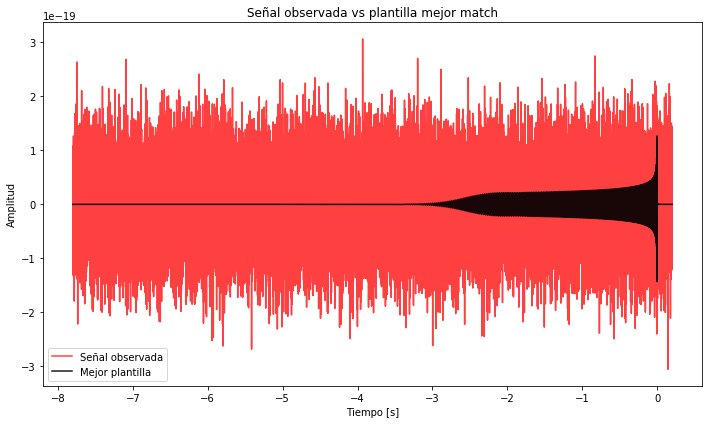

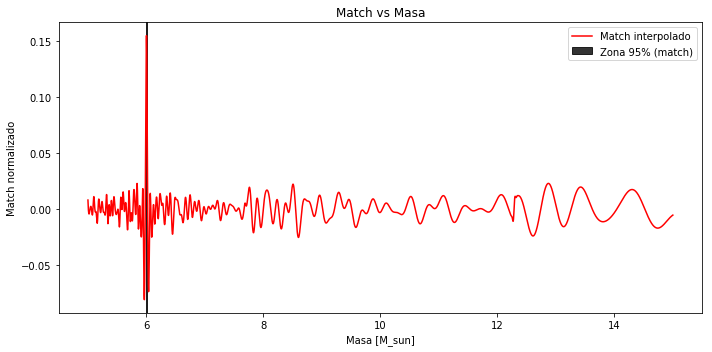

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import interp1d
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries

# --- 0. Configuración ---
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 40.0
true_mass = 6.0

# --- 1. Generar señal "verdadera" ---
hp_rom, _ = get_td_waveform(approximant='SEOBNRv4_ROM',
                            mass1=true_mass, mass2=true_mass,
                            delta_t=delta_t, f_lower=f_low)

signal = np.array(hp_rom)
t = hp_rom.sample_times

# --- 2. Señal observada con ruido gaussiano (sin PSD, método se mantiene) ---
gaussian_noise = np.random.normal(size=len(signal))
scaled_noise = gaussian_noise * np.max(np.abs(signal)) * 0.5  # intensidad de ruido
observed_signal = signal + scaled_noise

observed_ts = TimeSeries(observed_signal, delta_t=delta_t)
observed_ts.start_time = hp_rom.start_time

# --- 3. Rango de masas (m1 = m2) ---
masses = np.linspace(5.0, 15.0, 500)
best_match = -np.inf
best_mass = None
match_values = []

# --- 4. Medición de tiempos ---
iter_times = []
t_start_total = time.time()
t_start_loop = time.time()

# --- 5. Evaluar cada masa (método igual: match normalizado) ---
for m in masses:
    iter_start = time.time()

    hp_trial, _ = get_td_waveform(approximant='SEOBNRv4_ROM',
                                  mass1=m, mass2=m,
                                  delta_t=delta_t, f_lower=f_low)

    # Ajustar longitud
    min_len = min(len(hp_trial), len(observed_ts))
    hp_trial = hp_trial[:min_len]
    obs = observed_ts[:min_len]

    # Inner product normalizado (cosine-like)
    ht = hp_trial.numpy()
    ob = obs.numpy()
    num = np.sum(ht * ob)
    den = np.sqrt(np.sum(ht**2) * np.sum(ob**2))
    match = num / den if den > 0 else -np.inf

    match_values.append(match)

    if match > best_match:
        best_match = match
        best_mass = m
        hp_best = hp_trial  # guardamos la mejor plantilla

    iter_end = time.time()
    iter_times.append(iter_end - iter_start)

t_end_loop = time.time()
t_end_total = time.time()

match_values = np.array(match_values)

# --- 6. Interpolación fina para incertidumbre y derivados ---
interp_func = interp1d(masses, match_values, kind='cubic')
fine_masses = np.linspace(masses.min(), masses.max(), 5000)
fine_match = interp_func(fine_masses)

# Incertidumbre 95%: zona donde match >= 95% del máximo
mask95 = fine_match >= 0.95 * best_match
if np.any(mask95):
    m_lo_95 = fine_masses[mask95].min()
    m_hi_95 = fine_masses[mask95].max()
    half_width_95 = 0.5 * (m_hi_95 - m_lo_95)
else:
    m_lo_95 = best_mass
    m_hi_95 = best_mass
    half_width_95 = 0.0

# Masa ponderada por match (tu métrica)
mass_weighted_match = np.sum(masses * match_values) / np.sum(match_values)

# Posterior "suave" a partir del match (softmax con escala automática)
# Escala tau ~ 1% del rango dinámico para dar nitidez sin ser delta
dm = np.max(fine_match) - np.min(fine_match)
tau = max(1e-6, 0.01 * dm)
w = np.exp((fine_match - np.max(fine_match)) / tau)   # estabilizado
post = w / np.sum(w)

# Media posterior e intervalo creíble 68% (16–84)
mean_post = np.sum(fine_masses * post)
cdf = np.cumsum(post)
m16 = np.interp(0.16, cdf, fine_masses)
m84 = np.interp(0.84, cdf, fine_masses)

# --- 7. Estadísticas de tiempo ---
total_time = t_end_total - t_start_total
loop_time = t_end_loop - t_start_loop
avg_time = loop_time / len(masses)

# --- 8. Resultados ---
print(u"=== Resultados (Método: Match Normalizado, Ruido Gaussiano) ===")
print(u"Masa estimada (máx match): {:.3f} M_sun".format(best_mass))
print(u"Match máximo: {:.6f}".format(best_match))
print(u"Incertidumbre 95% (criterio match ≥ 95% del máximo): ±{:.3f} M_sun (rango [{:.3f}, {:.3f}])"
      .format(half_width_95, m_lo_95, m_hi_95))
print("Masa ponderada por match: {:.3f} M_sun".format(mass_weighted_match))
print("--- Tiempos ---")
print(u"Tiempo total de la estimación: {:.3f} s".format(total_time))
print("Tiempo total dentro del bucle: {:.3f} s".format(loop_time))
print("Tiempo promedio por masa: {:.3f} s".format(avg_time))
print("Tiempo por iteración (primeras 5): {}".format(
    " | ".join("{:.3f}".format(x) for x in iter_times[:5])
))

# --- 9. Gráfico 1: señal vs plantilla ---
# Alinear por superposición de tiempos válidos
start_time = max(hp_best.start_time, observed_ts.start_time)
end_time = min(hp_best.end_time, observed_ts.end_time)
hp_best_aligned = hp_best.time_slice(start_time, end_time)
obs_aligned = observed_ts.time_slice(start_time, end_time)

plt.figure(figsize=(10,6))
plt.plot(obs_aligned.sample_times, obs_aligned, label=u"Señal observada", alpha=0.75, color='red')
plt.plot(hp_best_aligned.sample_times, hp_best_aligned, label=u"Mejor plantilla", alpha=0.9, color='black')
plt.xlabel(u"Tiempo [s]")
plt.ylabel(u"Amplitud")
plt.title(u"Señal observada vs plantilla mejor match")
plt.legend()
plt.tight_layout()
plt.show()

# --- 10. Gráfico 2: match vs masa ---
plt.figure(figsize=(10,5))
plt.plot(fine_masses, fine_match,color='red', label="Match interpolado")
plt.axvspan(m_lo_95, m_hi_95, alpha=0.8,color='black', label="Zona 95% (match)")
plt.xlabel("Masa [M_sun]")
plt.ylabel("Match normalizado")
plt.title("Match vs Masa")
plt.legend()
plt.tight_layout()
plt.show()


=== Resultados (Método: Match Normalizado, Ruido Coloreado) ===
Masa estimada (máx match): 6.002 M_sun
Match máximo: 0.979388
Incertidumbre 95%: ±0.003 M_sun (rango [5.998, 6.004])
Masa ponderada por match: 15.693 M_sun
Posterior suave 68%: [5.998, 6.001] M_sun; media posterior = 6.001 M_sun
--- Tiempos ---
Tiempo total de la estimación: 23.117 s
Tiempo total dentro del bucle: 23.117 s
Tiempo promedio por masa: 0.046 s
Tiempo por iteración (primeras 5): 0.052 | 0.051 | 0.057 | 0.058 | 0.060


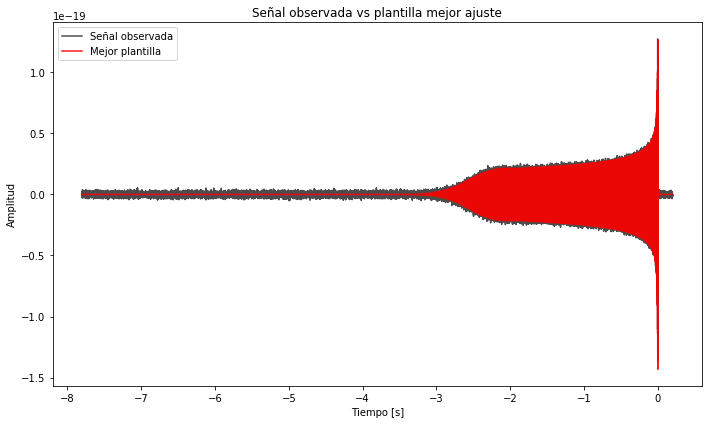

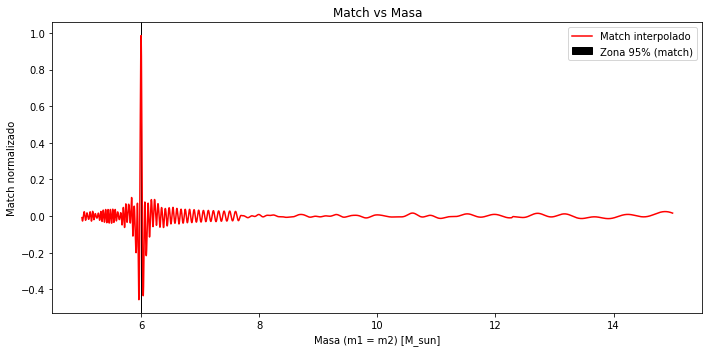

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import interp1d
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise.gaussian import noise_from_psd
from pycbc.types import TimeSeries

# --- 1. Generar señal simulada ---
delta_t = 1.0 / 4096
true_mass = 6.0  # masa real

hp, _ = get_td_waveform(approximant="SEOBNRv4_ROM",
                        mass1=true_mass, mass2=true_mass,
                        delta_t=delta_t, f_lower=40)

# --- 2. Generar PSD y ruido coloreado ---
psd = aLIGOZeroDetHighPower(len(hp)//2 + 1, 1.0/hp.duration, 20)
noise = noise_from_psd(len(hp), delta_t, psd, seed=123)
noise *= 5.0
noise.start_time = hp.start_time

# Señal observada
observed = hp + noise

# --- 3. Rango de masas ---
masses = np.linspace(5.0, 15.0, 500)
best_match = -np.inf
best_mass = None
match_values = []
iter_times = []

# --- medir tiempo total ---
t_start_total = time.time()
t_start_loop = time.time()

# --- 4. Evaluar cada masa ---
for m in masses:
    iter_start = time.time()

    hp_trial, _ = get_td_waveform(approximant="SEOBNRv4_ROM",
                                  mass1=m, mass2=m,
                                  delta_t=delta_t, f_lower=40)

    min_len = min(len(hp_trial), len(observed))
    hp_trial = hp_trial[:min_len]
    obs = observed[:min_len]

    # Inner product normalizado
    ht = hp_trial.numpy()
    ob = obs.numpy()
    num = np.sum(ht * ob)
    den = np.sqrt(np.sum(ht**2) * np.sum(ob**2))
    match = num / den if den > 0 else -np.inf

    match_values.append(match)

    if match > best_match:
        best_match = match
        best_mass = m
        hp_best = hp_trial

    iter_end = time.time()
    iter_times.append(iter_end - iter_start)

t_end_loop = time.time()
t_end_total = time.time()

match_values = np.array(match_values)

# --- 5. Interpolación e incertidumbre ---
interp_func = interp1d(masses, match_values, kind='cubic')
fine_masses = np.linspace(masses.min(), masses.max(), 5000)
fine_match = interp_func(fine_masses)

mask95 = fine_match >= 0.95 * best_match
if np.any(mask95):
    m_lo_95 = fine_masses[mask95].min()
    m_hi_95 = fine_masses[mask95].max()
    half_width_95 = 0.5 * (m_hi_95 - m_lo_95)
else:
    m_lo_95 = best_mass
    m_hi_95 = best_mass
    half_width_95 = 0.0

# --- 6. Ponderados y posterior ---
mass_weighted = np.sum(masses * match_values) / np.sum(match_values)

rho_shift = fine_match - fine_match.max()
w_post = np.exp(rho_shift / 0.01)  # escala suave
post = w_post / np.sum(w_post)
mean_post = np.sum(fine_masses * post)
cdf = np.cumsum(post)
m16 = np.interp(0.16, cdf, fine_masses)
m84 = np.interp(0.84, cdf, fine_masses)

# --- 7. Tiempos ---
total_time = t_end_total - t_start_total
loop_time = t_end_loop - t_start_loop
avg_time = loop_time / len(masses)

# --- 8. Resultados ---
print("=== Resultados (Método: Match Normalizado, Ruido Coloreado) ===")
print("Masa estimada (máx match): {:.3f} M_sun".format(best_mass))
print("Match máximo: {:.6f}".format(best_match))
print("Incertidumbre 95%: ±{:.3f} M_sun (rango [{:.3f}, {:.3f}])"
      .format(half_width_95, m_lo_95, m_hi_95))
print("Masa ponderada por match: {:.3f} M_sun".format(mass_weighted))
print("Posterior suave 68%: [{:.3f}, {:.3f}] M_sun; media posterior = {:.3f} M_sun"
      .format(m16, m84, mean_post))
print("--- Tiempos ---")
print("Tiempo total de la estimación: {:.3f} s".format(total_time))
print("Tiempo total dentro del bucle: {:.3f} s".format(loop_time))
print("Tiempo promedio por masa: {:.3f} s".format(avg_time))
print("Tiempo por iteración (primeras 5): {}".format(
    " | ".join("{:.3f}".format(x) for x in iter_times[:5])
))

# --- 9. Gráfico señal observada vs plantilla ---
start_time = max(hp_best.start_time, observed.start_time)
end_time = min(hp_best.end_time, observed.end_time)
hp_best_aligned = hp_best.time_slice(start_time, end_time)
obs_aligned = observed.time_slice(start_time, end_time)

plt.figure(figsize=(10,6))
plt.plot(obs_aligned.sample_times, obs_aligned, label="Señal observada", color='black', alpha=0.7)
plt.plot(hp_best_aligned.sample_times, hp_best_aligned, label="Mejor plantilla", color='red', alpha=0.9)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal observada vs plantilla mejor ajuste")
plt.legend()
plt.tight_layout()
plt.show()

# --- 10. Gráfico match vs masa ---
plt.figure(figsize=(10,5))
plt.plot(fine_masses, fine_match, color='red', label="Match interpolado")
plt.axvspan(m_lo_95, m_hi_95, alpha=1, color="black", label="Zona 95% (match)")
plt.xlabel("Masa (m1 = m2) [M_sun]")
plt.ylabel("Match normalizado")
plt.title("Match vs Masa")
plt.legend()
plt.tight_layout()
plt.show()
